This notebook is just a display in steps for you to view the process. The optimization, training, sparsifying, quantizing and automation are handled and done through the run_experimets.py . Please have a look

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

1. Data perepatation


Setting global variables that are static during the experiment. Please note that on the git version, we wont push the data but give you access from where to download it

In [2]:
DATA_DIR = 'data'
Image_dir = os.path.join(DATA_DIR, 'jpeg')
CSV_dir = os.path.join(DATA_DIR, 'csv')

In [3]:
# Read the csv file
df_user_based = pd.read_csv(os.path.join(CSV_dir, 'dicom_info.csv'))

In [4]:
df_user_based.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [5]:
# show basic information of the dataset
df_user_based.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   file_path                                    10237 non-null  object 
 1   image_path                                   10237 non-null  object 
 2   AccessionNumber                              0 non-null      float64
 3   BitsAllocated                                10237 non-null  int64  
 4   BitsStored                                   10237 non-null  int64  
 5   BodyPartExamined                             10237 non-null  object 
 6   Columns                                      10237 non-null  int64  
 7   ContentDate                                  10237 non-null  int64  
 8   ContentTime                                  10237 non-null  float64
 9   ConversionType                               10237 non-null  object 
 10

In [6]:
train_data_meta = pd.read_csv(os.path.join(CSV_dir, 'calc_case_description_train_set.csv'))
test_data_meta = pd.read_csv(os.path.join(CSV_dir, 'calc_case_description_test_set.csv'))

In [7]:
train_data_meta.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...


In [8]:
# show basic information of the dataset
train_data_meta.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1546 entries, 0 to 1545
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1546 non-null   object
 1   breast density           1546 non-null   int64 
 2   left or right breast     1546 non-null   object
 3   image view               1546 non-null   object
 4   abnormality id           1546 non-null   int64 
 5   abnormality type         1546 non-null   object
 6   calc type                1526 non-null   object
 7   calc distribution        1170 non-null   object
 8   assessment               1546 non-null   int64 
 9   pathology                1546 non-null   object
 10  subtlety                 1546 non-null   int64 
 11  image file path          1546 non-null   object
 12  cropped image file path  1546 non-null   object
 13  ROI mask file path       1546 non-null   object
dtypes: int64(4), object(10)
memory usage: 16

In [9]:
# show the number of images in each class
train_data_meta['pathology'].value_counts()

MALIGNANT                  544
BENIGN                     528
BENIGN_WITHOUT_CALLBACK    474
Name: pathology, dtype: int64

<AxesSubplot: >

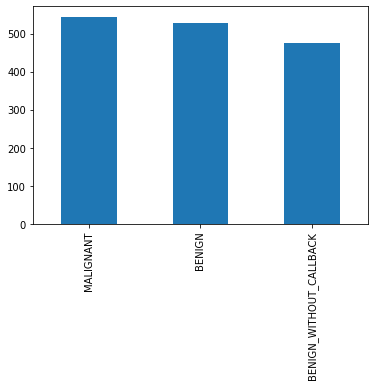

In [10]:
# histogram of the number of images in each class
train_data_meta['pathology'].value_counts().plot(kind='bar')

Reconstructing the path based on our data 

In [11]:
image_path = train_data_meta['image file path'][3].split('/')[-2]
print(image_path)


1.3.6.1.4.1.9590.100.1.2.104743410411133110629448544090466900446


In [16]:
# do same for all images
folder_path = [os.path.join(Image_dir,i.split('/')[-2]) for i in train_data_meta['image file path']]
folder_crop = [os.path.join(Image_dir,i.split('/')[-2]) for i in train_data_meta['cropped image file path']]
print(folder_path[0:5])
print()
print(folder_crop[0:5])

['data/jpeg/1.3.6.1.4.1.9590.100.1.2.47414316010368386519740343172775938548', 'data/jpeg/1.3.6.1.4.1.9590.100.1.2.250596608311207922527805669693579696727', 'data/jpeg/1.3.6.1.4.1.9590.100.1.2.228699627313487111012474405462022068297', 'data/jpeg/1.3.6.1.4.1.9590.100.1.2.104743410411133110629448544090466900446', 'data/jpeg/1.3.6.1.4.1.9590.100.1.2.406725628213826290127343763811145520834']

['data/jpeg/1.3.6.1.4.1.9590.100.1.2.393344010211719049419601138200355094682', 'data/jpeg/1.3.6.1.4.1.9590.100.1.2.296281207812130400303493285473798422894', 'data/jpeg/1.3.6.1.4.1.9590.100.1.2.314135871111943890422150247820137952041', 'data/jpeg/1.3.6.1.4.1.9590.100.1.2.91458279612485515203413781822560852485', 'data/jpeg/1.3.6.1.4.1.9590.100.1.2.281397494612871934937455783843630775495']


In [18]:
# os dir the folder path and get the jpg 0
train_data_meta['raw_image_path'] = [os.path.join(i,os.listdir(i)[0]) for i in folder_path]

In [19]:
train_data_meta['raw_image_path'].iloc[0]

'data/jpeg/1.3.6.1.4.1.9590.100.1.2.47414316010368386519740343172775938548/1-188.jpg'

Encoding the target for the DL model and applying filtering

In [20]:
mapping = {'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0, 'MALIGNANT': 1, 'MALIGNANT_WITHOUT_CALLBACK': 1}

In [21]:
train_df_filtered = train_data_meta.drop(['image file path', 'cropped image file path', 'ROI mask file path'], axis=1)

In [22]:
train_df_filtered['pathology'] = train_df_filtered['pathology'].map(mapping)

Viewing random pictures of the dataset. Please note that the images are black and white and it is just matplotlib as usual editing colors during display. We didnt want to use other libraries, especially cv2, because it might hang

data/jpeg/1.3.6.1.4.1.9590.100.1.2.304348734811652940137241355930439088639/1-004.jpg


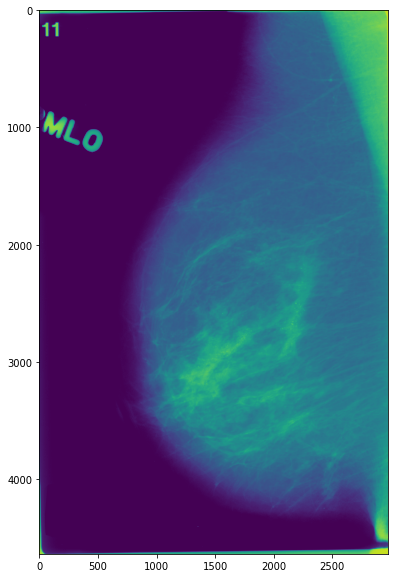

data/jpeg/1.3.6.1.4.1.9590.100.1.2.240083953312933883416427401150365051531/1-250.jpg


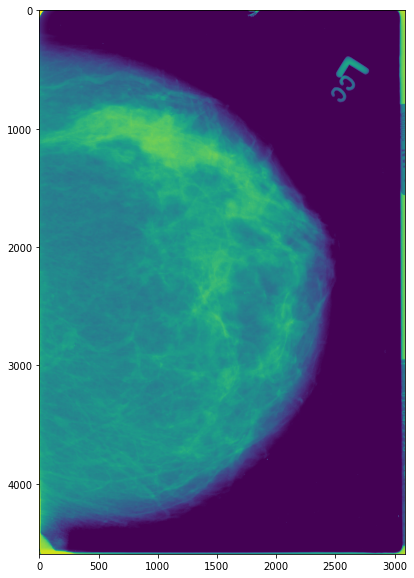

data/jpeg/1.3.6.1.4.1.9590.100.1.2.388598031012281869033964817213790777736/1-093.jpg


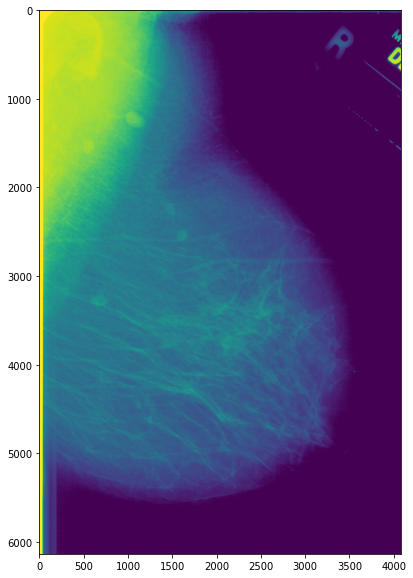

data/jpeg/1.3.6.1.4.1.9590.100.1.2.286720820911422039305674901973538322342/1-220.jpg


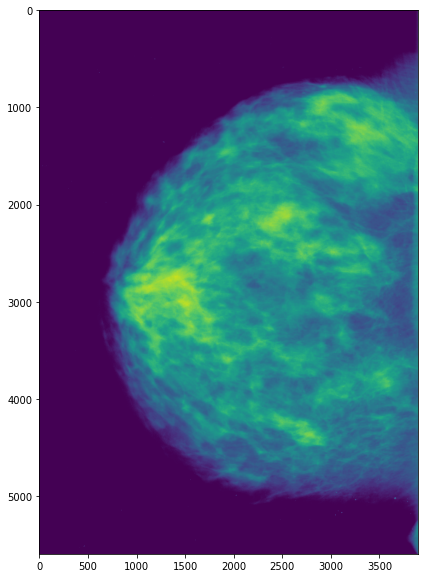

data/jpeg/1.3.6.1.4.1.9590.100.1.2.195093935411888015003069930313705725219/1-138.jpg


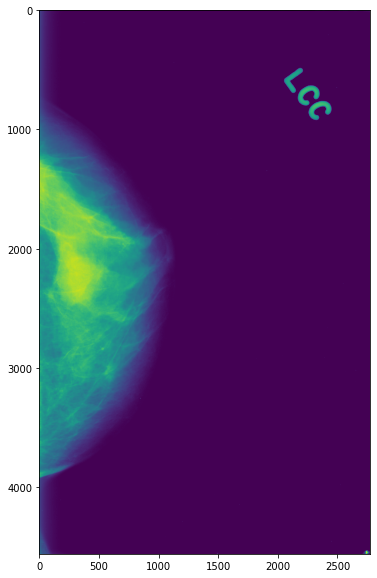

data/jpeg/1.3.6.1.4.1.9590.100.1.2.361006687412978352026930392572898355185/1-025.jpg


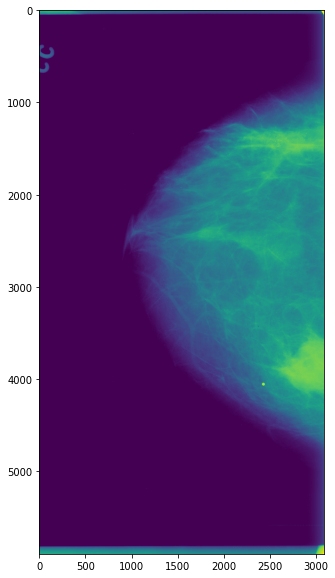

data/jpeg/1.3.6.1.4.1.9590.100.1.2.313741015210293714629835278293752843503/1-145.jpg


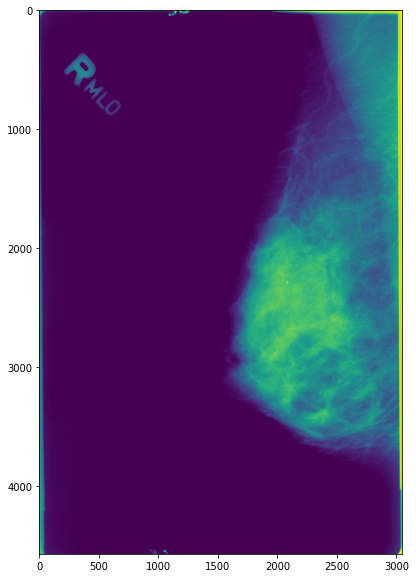

data/jpeg/1.3.6.1.4.1.9590.100.1.2.107975713012577821628078911051705957483/1-139.jpg


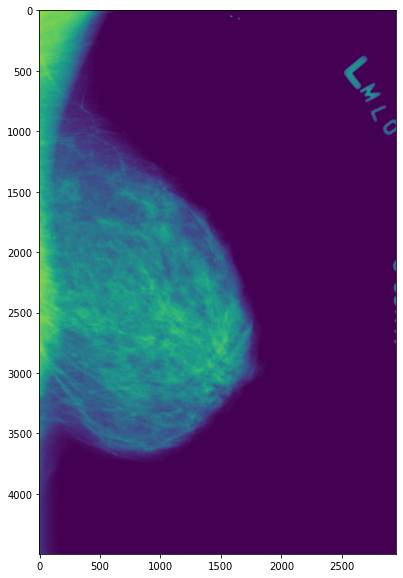

data/jpeg/1.3.6.1.4.1.9590.100.1.2.247478563813385502806126434882707296853/1-123.jpg


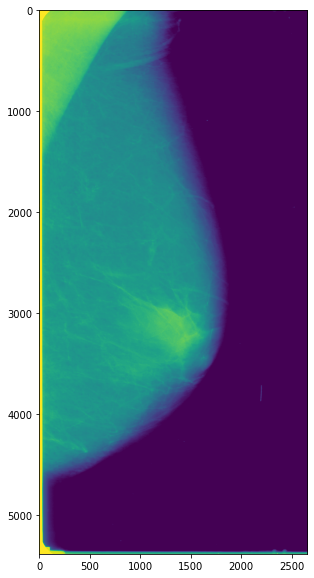

data/jpeg/1.3.6.1.4.1.9590.100.1.2.80636220111619759840797390173465079104/1-165.jpg


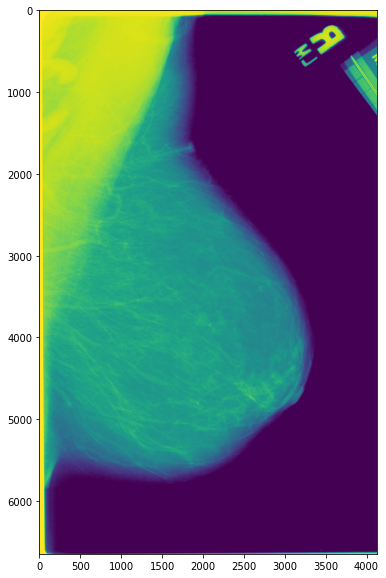

In [23]:
# show one raw image 
random_index = np.random.randint(0, len(train_df_filtered), 10)
for i in random_index:
    plt.figure(figsize=(10,10))
    plt.subplot(1,1,1)
    plt.imshow(Image.open(train_df_filtered['raw_image_path'].iloc[i]))
    print(train_df_filtered['raw_image_path'].iloc[i])
    plt.show()


In [24]:
# read and save  10 images for the backend guy to check 
dict = {}
for i in range(10):
    dict = {i:np.array(Image.open(train_df_filtered['raw_image_path'].iloc[i]))}

# export the 10 images to the backend guy as a numpy array
np.save('data.npy', dict)



In [25]:
# reading a npy file
data = np.load('data.npy', allow_pickle=True).item()
print(data)

{9: array([[255, 255, 255, ..., 238, 238, 238],
       [255, 255, 255, ..., 238, 238, 238],
       [255, 255, 255, ..., 238, 238, 238],
       ...,
       [197, 223, 226, ..., 162, 165, 169],
       [191, 208, 227, ..., 159, 165, 170],
       [199, 188, 215, ..., 155, 164, 170]], dtype=uint8)}


In [26]:
train_df_filtered.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,raw_image_path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,1,3,data/jpeg/1.3.6.1.4.1.9590.100.1.2.47414316010...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,1,3,data/jpeg/1.3.6.1.4.1.9590.100.1.2.25059660831...
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,0,4,data/jpeg/1.3.6.1.4.1.9590.100.1.2.22869962731...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,0,4,data/jpeg/1.3.6.1.4.1.9590.100.1.2.10474341041...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,0,3,data/jpeg/1.3.6.1.4.1.9590.100.1.2.40672562821...


In [28]:
# create train and test data set with target and raw image path read with pillow
train_df= train_df_filtered[['pathology','raw_image_path']]
# copy train_df and concatinated with the train_df with the same image path but with mask image path
#train_df_mask = train_df.copy()
#train_df_mask['raw_image_path'] = train_df_filtered['image_mask']
#train_df = pd.concat([train_df,train_df_mask],axis=0)
train_df.head()

,pathology,raw_image_path
0,1,data/jpeg/1.3.6.1.4.1.9590.100.1.2.47414316010...
1,1,data/jpeg/1.3.6.1.4.1.9590.100.1.2.25059660831...
2,0,data/jpeg/1.3.6.1.4.1.9590.100.1.2.22869962731...
3,0,data/jpeg/1.3.6.1.4.1.9590.100.1.2.10474341041...
4,0,data/jpeg/1.3.6.1.4.1.9590.100.1.2.40672562821...


Splitting the data into train and val

In [29]:
# split the data into train and validation set
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)


## Dataloader

In [30]:
# create data loader
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch
# create a class for the dataset for the train and validation set
class CancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 1]
        image = Image.open(img_name)
        label = self.df.iloc[idx, 0]
        if self.transform:
            image = self.transform(image)
        return image, label

# create a transform for the data
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))])


# create the train and validation dataset
train_dataset = CancerDataset(train_df, transform=transform)
val_dataset = CancerDataset(val_df, transform=transform)

# create the train and validation dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)



## NN implemetation

In [31]:
# create a class for the model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# use a pretrained model
import torchvision.models as models

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = models.resnet50(pretrained=True)
        # change the first layer to accept single channel image
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # change the last layer to accept 2 classes
        self.model.fc = nn.Linear(2048, 2)
    

    def forward(self, x):
        x = self.model(x)
        return x


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
print(device)

cuda


In [34]:
# create the model
model = Net()
model.to(device)

Net(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): C

In [35]:
# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [36]:
# get keys of the dataloader
print(train_loader.dataset[0][0].shape)

torch.Size([1, 224, 224])


In [37]:
import wandb
import json

In [38]:
# read the api key from the json file
with open('wandbkey.json') as f:
    data = json.load(f)
wandb.login(key=data['Wandb_key'])

wandb: Currently logged in as: heatdh (di_tum_sigopt). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/dhahri/.netrc


True

In [39]:
def config_Wb(name):
        """ Configure wb
        """
        unique_id=wandb.util.generate_id()
        wandb.init(id=unique_id,name=name, project='cancer_cv', entity='heatdh')


In [40]:
config_Wb("train_aug_God_Tier")

wandb: Currently logged in as: heatdh. Use `wandb login --relogin` to force relogin


### The chosen images are extremely hard

In [41]:
# train the model for 10 epochs and validate after each epoch
for epoch in range(10):  # loop over the dataset multiple times
    wandb.watch(model)
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
         # train accuracy
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        train_acc = 100 * correct / total
        wandb.log({"train_acc": train_acc})
        wandb.log({"train_loss": loss})
        
    wandb.log({"loss": loss})

    # validate the model
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images = images.to(device)
            labels= labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    wandb.log({"val accuracy": correct/total})
    print('Accuracy of test unseen images: %d %%' % (
        100 * correct / total))

print('Finished Training')

Accuracy of test unseen images: 68 %
Accuracy of test unseen images: 74 %
Accuracy of test unseen images: 72 %
Accuracy of test unseen images: 73 %
Accuracy of test unseen images: 68 %
Accuracy of test unseen images: 72 %
Accuracy of test unseen images: 75 %
Accuracy of test unseen images: 72 %
Accuracy of test unseen images: 70 %
Accuracy of test unseen images: 75 %
Finished Training


In [42]:
classes = ['BENIGN','MALIGNANT' ]
n_classes = 2

In [43]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# get the predictions
all_preds = torch.tensor([]).to(device)
all_labels = torch.tensor([]).to(device)
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds = torch.cat((all_preds,outputs),dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)


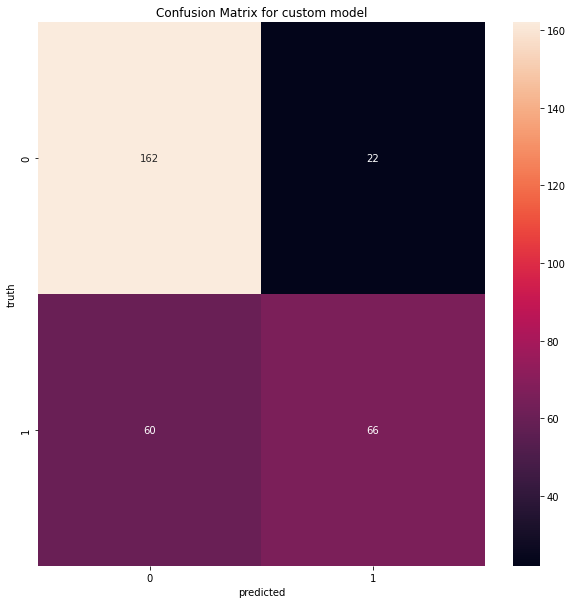

In [44]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# get the confusion matrix
cm = confusion_matrix(all_labels.cpu(), all_preds.argmax(dim=1).cpu())
# plot the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('predicted')
plt.ylabel('truth')
plt.title("Confusion Matrix for custom model")
plt.savefig("figures/confusion_matrix.png")
plt.show()

In [45]:
arr_label_test = all_labels.cpu().ravel() 
arr_preds_test = all_preds.argmax(dim=1).cpu().ravel()

In [46]:
print(arr_label_test.shape)
print(arr_preds_test.shape)

torch.Size([310])
torch.Size([310])


In [55]:
def plot_auc(arr_label_test,arr_preds_test):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import auc
    fpr, tpr, thresholds = roc_curve(arr_label_test, arr_preds_test)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
                lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [48]:
# save the model
torch.save(model.state_dict(), 'model_adam_0001.pth')

## Inference

In [49]:
# read an image and predict
import torch
import numpy as np
from PIL import Image

# load the model
model = Net()
model.load_state_dict(torch.load('model_adam_0001.pth'))

# read the image
img_title = 'Wednesday_Adams.jpg'
img = Image.open('test.jpg')
# transform the image
img = transform(img)
img = np.array(img)
img = img[np.newaxis, :, :, :]
# convert to tensor
img = torch.from_numpy(img)

# get the prediction
pred = model(img)
# get the index of the max log-probability
pred = pred.argmax(dim=1, keepdim=True).numpy()[0][0]
if pred == 0: 
    output_msg = f"The model predicted that the tumor is {classes[pred]}"
else : 
    output_msg = f"Madam {img_title.split('.')[0].replace('_',' ')} should be contacted as soon as possible and appointment should be prioritzied"
print(output_msg)

The model predicted that the tumor is BENIGN


## Quantizing to 8 bit

In [50]:
# quantizate the model for mobile
import torch
import torch.nn as nn
import torchvision.models as models

# load the model
model = Net()
model.load_state_dict(torch.load('model_adam_0001.pth'))

# quantize the model
model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
torch.quantization.prepare(model, inplace=True)
torch.quantization.convert(model, inplace=True)
# size of the model
print('Memory consumed in (MB):', torch.cuda.memory_allocated(0)/1e6)
# save the model
torch.save(model.state_dict(), 'model_quantized_god_adam_001_mobile.pth')

/home/dhahri/.local/lib/python3.8/site-packages/torch/quantization/observer.py:121: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/home/dhahri/.local/lib/python3.8/site-packages/torch/quantization/observer.py:955: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


Memory consumed in (MB): 394.38336


In [51]:
# quantizate the model for cloud
import torch
import torch.nn as nn
import torchvision.models as models

# load the model
model = Net()
model.load_state_dict(torch.load('model_adam_0001.pth'))

# quantize the model
model.qconfig = torch.quantization.get_default_qconfig('qnnpack')
torch.quantization.prepare(model, inplace=True)
torch.quantization.convert(model, inplace=True)
# memory allocated to quantize
print('Memory consumed in (MB):', torch.cuda.memory_allocated(0)/1e6)
# save the model
torch.save(model.state_dict(), 'model_quantized_god_adam_001_cloud.pth')

Memory consumed in (MB): 394.38336
